In [1]:
import time
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
import scipy
import pdb
import skimage
from skimage import measure

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def imread(path, is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.

  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

In [3]:
def preprocess(path, scale=3):
  """
  Preprocess single image file
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  
  input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
 

  return input_, label_



In [4]:
# print (ground_truth_image.shape)

In [5]:
"""Set the image hyper parameters
"""
c_dim = 1
input_size = 255

"""Define the model weights and biases
"""

# define the placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, [None, input_size, input_size, c_dim], name='inputs')

## ------ Add your code here: set the weight of three conv layers
# replace '0' with your hyper parameter numbers
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
weights = {
    'w1': tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')
    }
#
biases = {
      'b1': tf.Variable(tf.zeros([64]), name='b1'),
      'b2': tf.Variable(tf.zeros([32]), name='b2'),
      'b3': tf.Variable(tf.zeros([1]), name='b3')
    }
#
# """Define the model layers with three convolutional layers
# """
# ## ------ Add your code here: to compute feature maps of input low-resolution images
# # replace 'None' with your layers: use the tf.nn.conv2d() and tf.nn.relu()
# # conv1 layer with biases and relu : 64 filters with size 9 x 9
#
conv1 = tf.nn.relu(tf.nn.conv2d(inputs, weights['w1'], strides=[1,1,1,1], padding='VALID') + biases['b1'])
##------ Add your code here: to compute non-linear mapping
# # conv2 layer with biases and relu: 32 filters with size 1 x 1
#
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, weights['w2'], strides=[1,1,1,1], padding='VALID') + biases['b2'])
# ##------ Add your code here: compute the reconstruction of high-resolution image
# # conv3 layer with biases and NO relu: 1 filter with size 5 x 5
conv3 = tf.nn.conv2d(conv2, weights['w3'], strides=[1,1,1,1], padding='VALID') + biases['b3']


# pdb.set_trace()




In [6]:
model_path='./model/model.npy'
model = np.load(model_path, encoding = 'latin1').item() #latin1

In [7]:
# print (model)

### Weights Visualisation

In [8]:
weight_w1 = model['w1']
print (weight_w1.shape)

(9, 9, 1, 64)


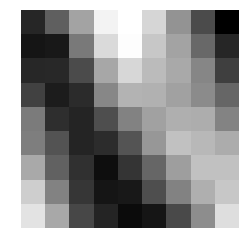

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [9]:
plt.imshow(weight_w1[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('w1_1.jpg', weight_w1[:,:,0,0])

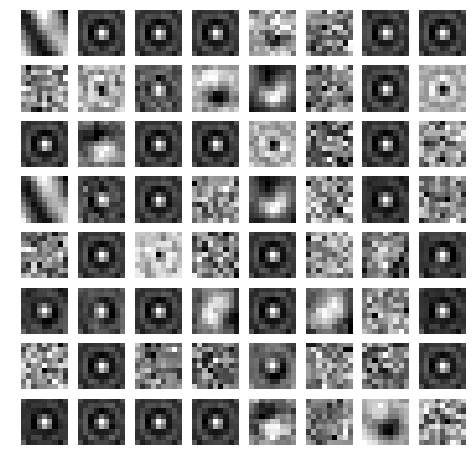

In [10]:
fig = plt.figure(figsize=(8,8)) #width, height in inches of the window size

for i in range(64): #number of filters
    sub = fig.add_subplot(8,8, i +1)
    sub.imshow(weight_w1[:,:,0,i], interpolation = None, cmap = 'gray')
    plt.axis('off')
plt.show()
fig.savefig('weight_1.jpg')

(1, 1, 64, 32)


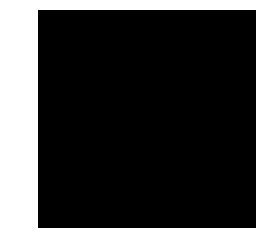

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [11]:
weight_w2 = model['w2']
print (weight_w2.shape)
plt.imshow(weight_w2[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('w2_2.jpg', weight_w2[:,:,0,0])

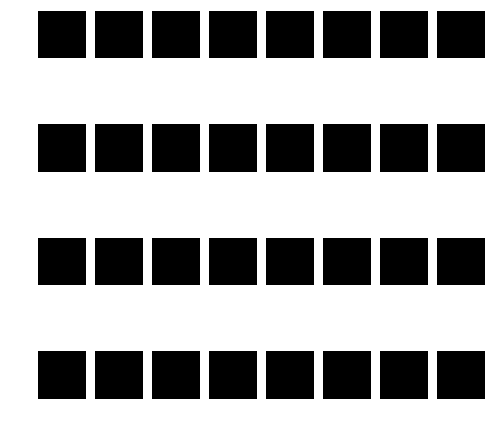

In [12]:
fig = plt.figure(figsize=(8,8)) #width, height in inches of the window size

for i in range(32): #number of filters
    sub = fig.add_subplot(4,8, i +1)
    sub.imshow(weight_w2[:,:,0,i], interpolation = None, cmap = 'gray')
    plt.axis('off')
plt.show()
fig.savefig('weight_2.jpg')

In [13]:
weight_w3 = model['w3']
print (weight_w3.shape)

(5, 5, 32, 1)


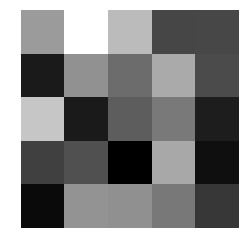

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


In [14]:
plt.imshow(weight_w3[:,:,0,0], interpolation = None, cmap = 'gray')
plt.axis('off')
plt.show()
scipy.misc.imsave('weight_3.jpg', weight_w3[:,:,0,0])

In [15]:
sess = tf.Session()

In [16]:

for key in weights.keys():
    print(key)
    sess.run(weights[key].assign(model[key]))

for key in biases.keys():
    print(key)
    sess.run(biases[key].assign(model[key]))

w1
w2
w3
b1
b2
b3


In [17]:
"""Read the test image
"""
blurred_image, groundtruth_image = preprocess('./image/butterfly_GT.bmp')
"""Run the model and get the SR image
"""
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(blurred_image, axis =0), axis=-1)

# # run the session
# # here you can also run to get feature map like 'conv1' and 'conv2'
output_ = sess.run(conv3, feed_dict={inputs: input_})



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [18]:
print(input_.shape)
print(blurred_image.shape)
print(output_.shape)
print(groundtruth_image.shape)
print (output_.shape)

print (type(input_))

(1, 255, 255, 1)
(255, 255)
(1, 243, 243, 1)
(255, 255)
(1, 243, 243, 1)
<class 'numpy.ndarray'>


In [19]:
##------ Add your code here: save the blurred and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.meause.compare_psnr()'
scipy.misc.imsave('Blurred.jpg', blurred_image)
scipy.misc.imsave('SR.jpg', output_[0,:,:,0])
scipy.misc.imsave('ground_truth.jpg',groundtruth_image)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


In [20]:
gt_2 = groundtruth_image[6:249,6:249] #convert the ground_truth to same size as SR image by cropping the edges

b1_1 = blurred_image[6:249,6:249]  #convert the blurred to same size as SR and ground_truth image by cropping the edges

sr_1 = output_[0,:,:,0].astype(np.float64) #convert the datatype of SR to same as blurred and groundtruth

#compute PSNR for Blurred Image with ground_truth image

psnr1 = skimage.measure.compare_psnr(gt_2, b1_1, data_range=None, dynamic_range=None) # BI psnr

#compute PSNR for SR Image with ground_truth image

psnr2 = skimage.measure.compare_psnr(gt_2, sr_1, data_range=None, dynamic_range=None) # SR psnr

print ("Blurred(BI) psnr: "+ str(psnr1))

print ("SR psnr: "+ str(psnr2))



Blurred(BI) psnr: 20.453967418499577
SR psnr: 21.77124830643141
